### GTEx

In [377]:
import senepy as sp
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sci
import numpy as np

In [385]:
gtex_raw = sc.read("/mnt/data1/wangj/MyProject/Data/GTEx/Bulk_SnRNA/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad")
gtex = gtex_raw.raw.to_adata()
gtex 

AnnData object with n_obs × n_vars = 209126 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', '

In [ ]:
mm_l2 = pd.read_csv('/home/wangjing/wangj/AgingScore/Data/Bulk_TrainModel/mm_l2.csv',index_col=0)

In [379]:
hubs = sp.load_hubs(species = 'Human')

In [380]:
### load the match Cell type
cell_map = pd.read_csv('HUSI/GTEx_SenePy.csv')
cell_map

,GTEx,Tissue_1,SenePy,Tissue_2
0,Endothelial cell (vascular);Endothelial cell (...,Lung,endothelial cell,lung
1,Epithelial cell (basal),Lung,basal cell,lung
2,Epithelial cell (ciliated),Lung,ciliated epithelial cell,lung
3,Epithelial cell (club),Lung,club cell,lung
4,Fibroblast,Lung,fibroblast,lung
5,Immune (DC/macrophage);Immune (DC/macrophage),Lung,macrophage,lung
6,Immune (T cell),Lung,t cell,lung
7,Epithelial cell (alveolar type II),Lung,type ii pneumocyte,lung
8,Myocyte (cardiac),Heart,cardiomyocyte,heart
9,Adipocyte,Heart,adipocyte,heart


In [386]:
### subset gext data
cell_use = {}
cell_uses = []
meta = gtex.obs
for index,row in cell_map.iterrows():
    types = row[0].split(';')
    cell_use[row[2]+"_"+row[3]] = meta.loc[(meta['Tissue']==row[1]) & (meta['Broad cell type'].isin(types))].index.tolist()
    cell_uses = cell_uses + cell_use[row[2]+"_"+row[3]]

<AxesSubplot: >

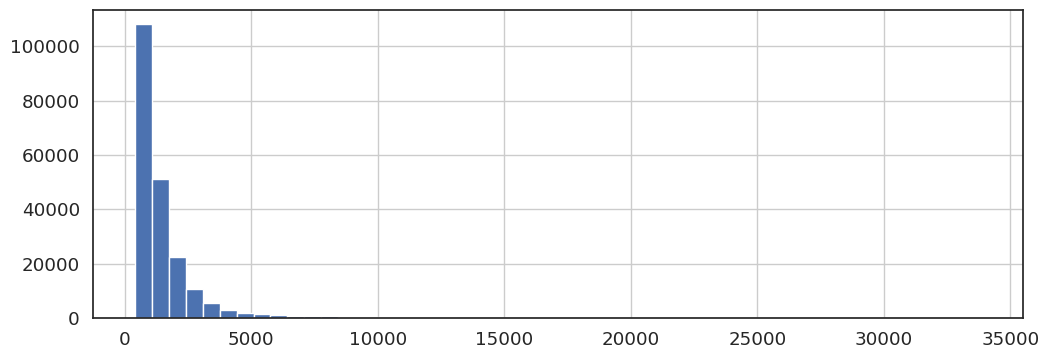

In [387]:
gtex.obs.nUMIs.hist(bins=50)

In [389]:
gtex = gtex[cell_uses,:]
sc.pp.normalize_total(gtex,target_sum=1e4)
sc.pp.log1p(gtex)
gtex

/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 50515 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

In [390]:
ScoresList = {}
for key in cell_use.keys():
    cell = key.split('_')[0]
    tissue = key.split('_')[1]
    sub_gtex = gtex[cell_use[key]]
    print(key,sub_gtex.shape[0])
    
    genes = set(mm_l2.index) & set(sub_gtex.var_names)

    exp = sub_gtex[:,list(genes)].X.todense()
    exp = pd.DataFrame(exp,index=sub_gtex.obs_names,columns=list(genes))
    hUSI = []
    for row in range(len(exp)):  
        hUSI.append(mm_l2.w.corr(exp.iloc[row],method='spearman'))

    hub_names =  [i for i in hubs.hubs.keys() if cell in i and tissue in i]
    ScoresList[key] = {}
    ScoresList[key]['SenePy'] = {}
    for hub in hub_names:
        ScoresList[key]['SenePy']['_'.join(str(element) for element in hub)] = sp.score_hub(sub_gtex,hubs.hubs[hub])

    ScoresList[key]['hUSI'] =  hUSI


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


endothelial cell_lung 2746


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

basal cell_lung 142


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

ciliated epithelial cell_lung 896


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

club cell_lung 660


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

fibroblast_lung 1476


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

macrophage_lung 921


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

t cell_lung 613


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

type ii pneumocyte_lung 15103


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

cardiomyocyte_heart 7041


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

adipocyte_heart 193


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

endothelial cell_heart 7635


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

fibroblast_heart 9287


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


lymphoid cell_heart 676


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

fibroblast_skin 529


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

basal cell_skin 1320


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

endothelial cell_skin 1023


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

immune cell_skin 254


/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [497]:
df_plot = pd.DataFrame()
for key in ScoresList.keys():
    cors = []
    for subkey in ScoresList[key]['SenePy'].keys():
        cors.append(sci.spearmanr(ScoresList[key]['SenePy'][subkey],ScoresList[key]['hUSI']).correlation)
    df_plot = pd.concat([df_plot,pd.DataFrame({'Cell type':key,'Cofficient':[np.max(cors)]})],ignore_index=True)

In [500]:
df_plot['tissue'] = df_plot['Cell type'].apply(lambda x: x.split('_')[1])
df_plot['type'] = df_plot['Cell type'].apply(lambda x: x.split('_')[0])
df_plot.tissue = pd.Categorical(df_plot.tissue,categories=['heart','skin','lung'],ordered=True)
df_plot = df_plot.sort_values(by='tissue',ascending=True,ignore_index=True)
df_plot

,Cell type,Cofficient,tissue,type
0,cardiomyocyte_heart,0.394962,heart,cardiomyocyte
1,lymphoid cell_heart,0.040764,heart,lymphoid cell
2,fibroblast_heart,0.425028,heart,fibroblast
3,endothelial cell_heart,0.182944,heart,endothelial cell
4,adipocyte_heart,-0.233769,heart,adipocyte
5,basal cell_skin,-0.174568,skin,basal cell
6,fibroblast_skin,0.351446,skin,fibroblast
7,endothelial cell_skin,0.105077,skin,endothelial cell
8,immune cell_skin,0.339560,skin,immune cell
9,t cell_lung,-0.114488,lung,t cell


In [501]:
df_plot['counts'] = df_plot['Cell type'].apply(lambda x: len(cell_use[x]))

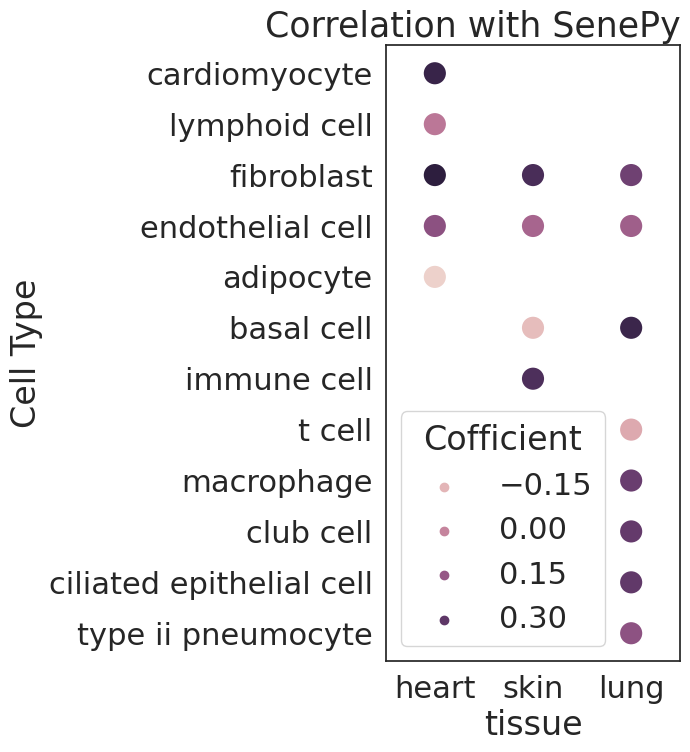

In [505]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2,style='white')
plt.figure(figsize=(3.8,8))
ax = sns.scatterplot(x='tissue',y='type',hue='Cofficient',data=df_plot,s = 300)
plt.title('Correlation with SenePy',fontsize=25,loc='right')
plt.ylabel('Cell Type')
plt.xlim(-0.5, 3 - 0.5)
plt.savefig("HUSI/Figures/model/GTEx_SenePy.png",dpi = 400,bbox_inches = 'tight')

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt

In [2]:
meta = pd.read_csv('/home/wangjing/wangj/AgingScore/GSE171524_NormalLung/lung_metaData.txt',index_col=0,sep='\t')
### remove 1 row
meta = meta.drop(['TYPE'],axis=0)
meta

/tmp/ipykernel_38150/820619250.py:1: DtypeWarning: Columns (15,16,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/home/wangjing/wangj/AgingScore/GSE171524_NormalLung/lung_metaData.txt',index_col=0,sep='\t')


,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,...,cell_type_intermediate,cell_type_fine,initial_clustering,age,sex,recorded_race,recorded_ethnicity,intubation_days,interval_death_symptoms_onset_days,pmi_h
NAME,,,,,,,,,,,,,,,,,,,,,
ATTCACTGTAACAGGC-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
TAACTTCCAACCACGC-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Macrophages,Alveolar macrophages,3,70,female,White,not_hispanic,NaN,NaN,NaN
TTGGGTACACGACAAG-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
AGGCCACAGAGTCACG-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
CACTGAAGTCGAAGCA-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTAAGAAGTTGTCAC-1_27,L22cov,L22cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Fibroblasts,Intermediate pathological FB,0,58,male,NaN,NaN,56,63,6.75
CGTGAATCATGTCTAG-1_27,L22cov,L22cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,Macrophages,Transitioning MDM,9,58,male,NaN,NaN,56,63,6.75
GCCGATGAGTAAACGT-1_27,L22cov,L22cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,...,AT2,AT2,11,58,male,NaN,NaN,56,63,6.75


In [3]:
meta.cell_type_fine.value_counts()

Alveolar macrophages                  12511
AT2                                   11341
AT1                                    9608
Monocyte-derived macrophages           9534
Intermediate pathological FB           8779
CD4+ T cells                           7586
Plasma cells                           5391
Alveolar FB                            4670
Transitioning MDM                      4203
Adventitial FB                         3773
CD8+ T cells                           3561
Monocytes                              3176
Cycling NK/T cells                     2814
Airway ciliated                        2392
Pathological FB                        2322
NK cells                               2141
Neuronal cells                         2017
Airway goblet                          1757
Mast cells                             1438
Endothelial cells (general)            1360
Airway mucous                          1307
Activated B cells                      1299
Airway club                     

In [4]:
### read counts
files = os.listdir('/home/wangjing/wangj/AgingScore/GSE171524_NormalLung/Counts')
counts = pd.DataFrame()
cells = []
for file in files:
    tmp = pd.read_csv('/home/wangjing/wangj/AgingScore/GSE171524_NormalLung/Counts/'+file,index_col=0)
    tmp = tmp.T
    cells = cells + tmp.index.tolist()
    counts = pd.concat([counts,tmp],ignore_index=True)                            

In [5]:
import collections as clt
clt.Counter(meta.index.isin(cells))

Counter({True: 116313})

In [6]:
counts.index = cells
counts = counts.loc[meta.index,:]

In [7]:
adata = sc.AnnData(counts)
adata.obs = meta
adata

AnnData object with n_obs × n_vars = 116313 × 34546
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h'

(array([1.0962e+05, 5.3780e+03, 9.1500e+02, 2.4100e+02, 8.7000e+01,
        4.2000e+01, 1.5000e+01, 1.0000e+01, 3.0000e+00, 2.0000e+00]),
 array([  401.,  3842.,  7283., 10724., 14165., 17606., 21047., 24488.,
        27929., 31370., 34811.]),
 <BarContainer object of 10 artists>)

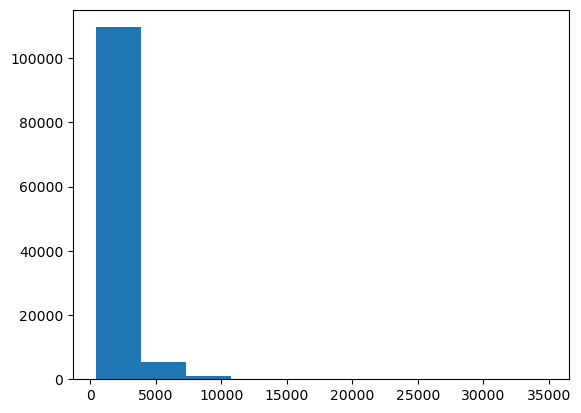

In [8]:
plt.hist(adata.X.sum(axis=1))

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'biosample_id' as categorical
... storing 'donor_id' as categorical
... storing 'species' as categorical
... storing 'species__ontology_label' as categorical
... storing 'disease' as categorical
... storing 'disease__ontology_label' as categorical
... storing 'organ' as categorical
... storing 'organ__ontology_label' as categorical
... storing 'library_preparation_protocol' as categorical
... storing 'library_preparation_protocol__ontology_label' as categorical
... storing 'group' as categorical
... storing 'cell_type_main' as categorical
... storing 'cell_type_intermediate' as categorical
... storing 'cell_type_fine' as categorical
... storing 'initial_clustering' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'recorded_race' as categorical
... storing 'recorded_ethnicity' as categorical
... storing 'intubation_days' as categorical
... storing 'interval_death_symptoms_onset_days' as categorical
... storing 'pmi_h' as categorica

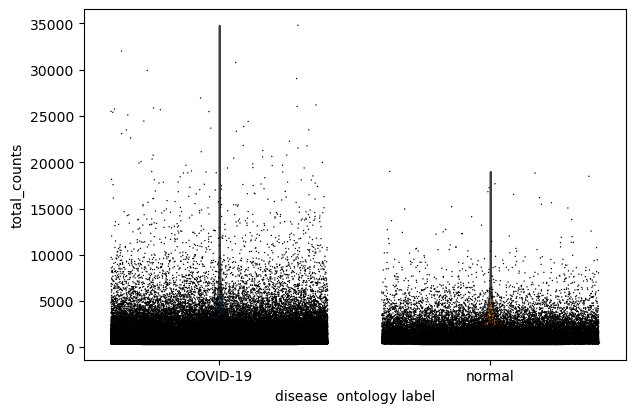

In [10]:
sc.pl.violin(adata, keys=['total_counts'],groupby='disease__ontology_label',jitter=0.4, multi_panel=True)

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


<AxesSubplot: >

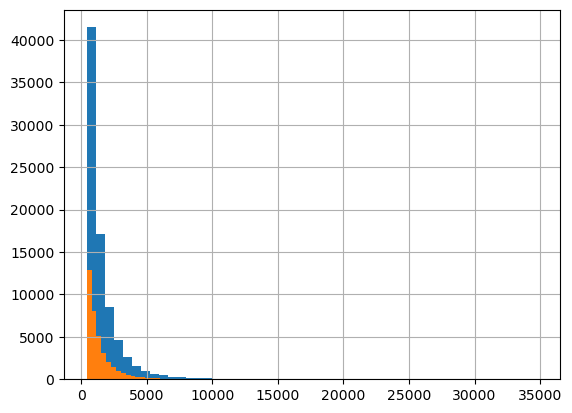

In [12]:
adata[adata.obs.disease__ontology_label == 'COVID-19',:].obs.total_counts.hist(bins=50)
adata[adata.obs.disease__ontology_label == 'normal',:].obs.total_counts.hist(bins=50)
# plt.hist(list(adata[adata.obs.disease__ontology_label == 'COVID-19',:].X.sum(axis=1)))
# plt.hist(list(adata[adata.obs.disease__ontology_label == 'normal',:].X.sum(axis=1)))

In [13]:
adata.obs.disease__ontology_label.value_counts()

COVID-19    79636
normal      36677
Name: disease__ontology_label, dtype: int64

In [14]:
mm_l2 = pd.read_csv('/home/wangjing/wangj/AgingScore/Data/Bulk_TrainModel/mm_l2.csv',index_col=0)

In [15]:
adata.obs.cell_type_fine.value_counts()

Alveolar macrophages                  12511
AT2                                   11341
AT1                                    9608
Monocyte-derived macrophages           9534
Intermediate pathological FB           8779
CD4+ T cells                           7586
Plasma cells                           5391
Alveolar FB                            4670
Transitioning MDM                      4203
Adventitial FB                         3773
CD8+ T cells                           3561
Monocytes                              3176
Cycling NK/T cells                     2814
Airway ciliated                        2392
Pathological FB                        2322
NK cells                               2141
Neuronal cells                         2017
Airway goblet                          1757
Mast cells                             1438
Endothelial cells (general)            1360
Airway mucous                          1307
Activated B cells                      1299
Airway club                     

In [18]:
genes = set(mm_l2.index) & set(adata.var_names)

exp = adata[:,list(genes)].X
exp = pd.DataFrame(exp,index=adata.obs_names,columns=list(genes))
hUSI = []
for row in range(len(exp)):  
    hUSI.append(mm_l2.w.corr(exp.iloc[row],method='spearman'))

/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [19]:
adata.obs['hUSI'] = hUSI

<AxesSubplot: xlabel='cell_type_main', ylabel='hUSI'>

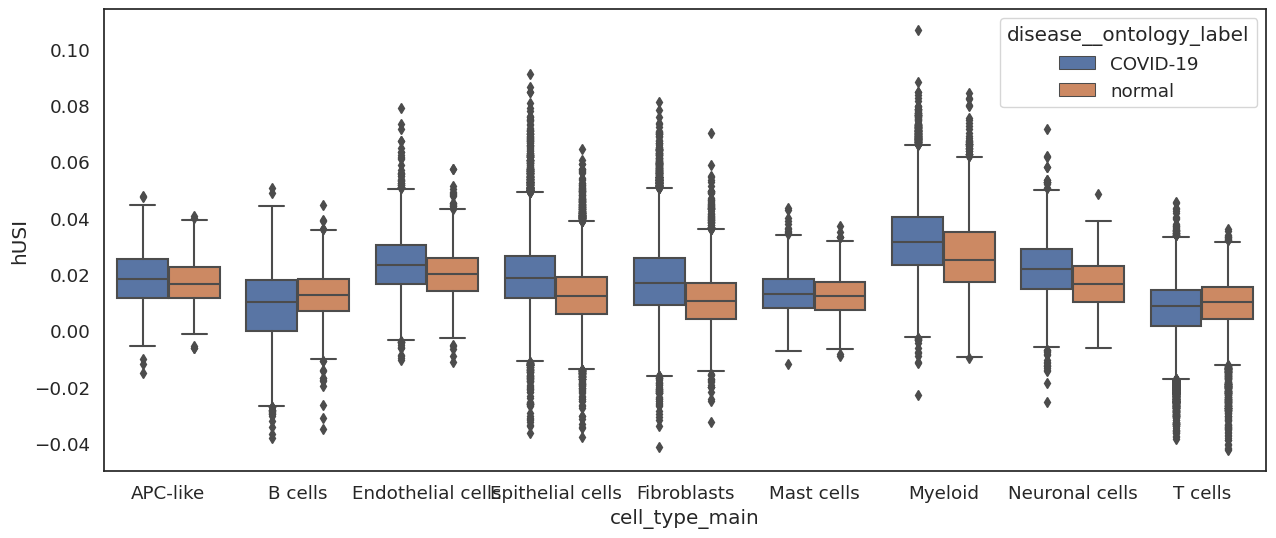

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,6)},font_scale=1.2)
sns.set_style("white")
sns.boxplot(hue='disease__ontology_label',y='hUSI',x = 'cell_type_main',data=adata.obs)

In [22]:
adata.obs.columns

Index(['biosample_id', 'donor_id', 'species', 'species__ontology_label',
       'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label',
       'library_preparation_protocol',
       'library_preparation_protocol__ontology_label', 'group',
       'cell_type_main', 'cell_type_intermediate', 'cell_type_fine',
       'initial_clustering', 'age', 'sex', 'recorded_race',
       'recorded_ethnicity', 'intubation_days',
       'interval_death_symptoms_onset_days', 'pmi_h', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'hUSI'],
      dtype='object')

In [103]:
import random
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import collections as clt

random.seed(123)
mclust = importr('mclust')
data = adata.obs['hUSI'].tolist()
data = [np.log2(1+i)/np.log2(1-i) for i in data]
r_data = FloatVector(data)
result = mclust.Mclust(r_data)  
clusters = result.rx2('classification')
clusters = list(clusters)
print(clt.Counter(clusters))

fitting ...
  |======================================================================| 100%
Counter({2.0: 48563, 4.0: 29849, 3.0: 26688, 1.0: 11213})


In [104]:
adata.obs['age_class'] = pd.Categorical(['C'+str(int(i)) for i in clusters])

In [105]:
adata.obs['age_class'].value_counts()

C2    48563
C4    29849
C3    26688
C1    11213
Name: age_class, dtype: int64

<AxesSubplot: xlabel='cell_type_main', ylabel='hUSI'>

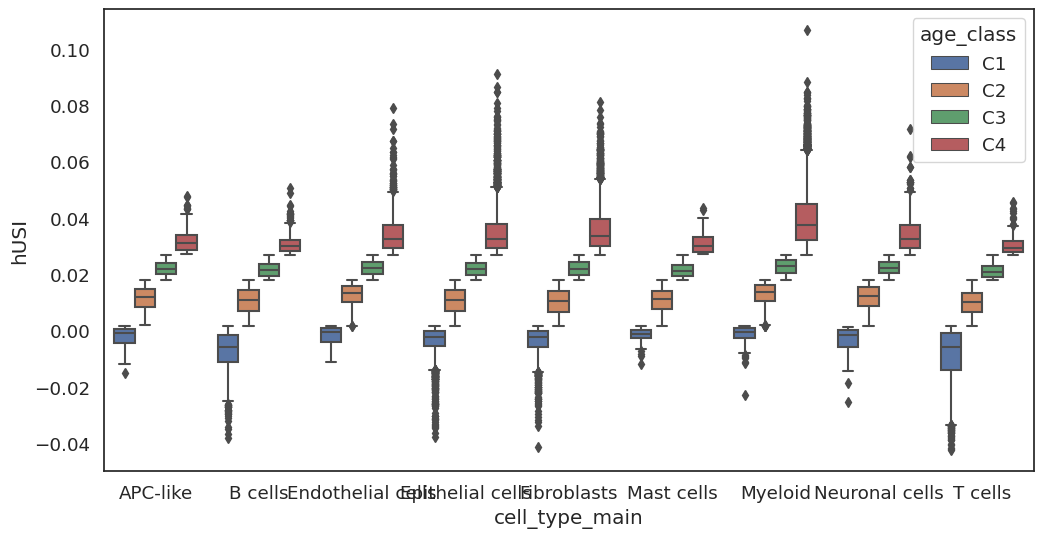

In [106]:
sns.set(rc={'figure.figsize':(12,6)},font_scale=1.2,style='white')
sns.boxplot(hue='age_class',y='hUSI',x='cell_type_main',data=adata.obs)

In [107]:
df_plot = adata.obs[['age_class','disease__ontology_label']].groupby(['age_class','disease__ontology_label']).size().reset_index().rename(columns={0:'count'})
df_plot['Fraction'] = df_plot['count'] / df_plot.groupby(['disease__ontology_label'])['count'].transform('sum')
df_plot['Sample'] = pd.Categorical(df_plot['disease__ontology_label'].apply(lambda x: 'COVID-19' if x == 'COVID-19' else 'Normal'),categories=['Normal','COVID-19'],ordered=True)
df_plot


,age_class,disease__ontology_label,count,Fraction,Sample
0,C1,COVID-19,6970,0.087523,COVID-19
1,C1,normal,4243,0.115686,Normal
2,C2,COVID-19,28513,0.358042,COVID-19
3,C2,normal,20050,0.546664,Normal
4,C3,COVID-19,18734,0.235245,COVID-19
5,C3,normal,7954,0.216866,Normal
6,C4,COVID-19,25419,0.319190,COVID-19
7,C4,normal,4430,0.120784,Normal


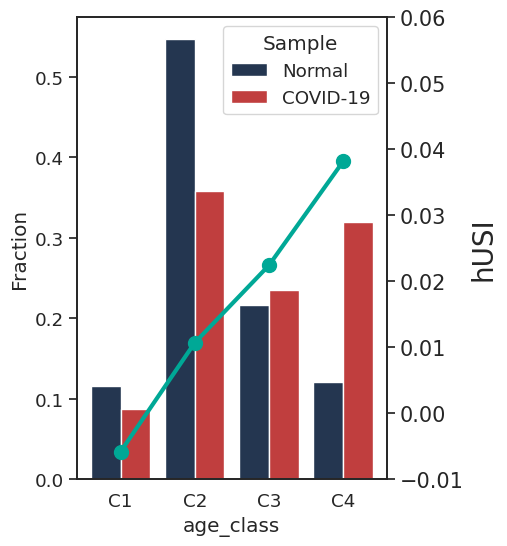

In [108]:
sns.set(rc={'figure.figsize':(4,6)},font_scale=1.2)
sns.set_style("white")
ax1 = sns.barplot(hue='Sample',y='Fraction',x='age_class',data=df_plot,palette=['#1d3557','#d62828'])
ax2 = ax1.twinx()  
ax2.set_ylim([-0.01, 0.06])      
ax2.plot(y.index, y.hUSI, '#00a896', ms=10, lw=3, marker='o') 
ax2.set_ylabel('hUSI', fontsize='20')
ax2.tick_params(labelsize=15)
plt.savefig("HUSI/Figures/model/Covid_hUSI.png",dpi = 400,bbox_inches = 'tight')


In [109]:
df = adata[adata.obs.disease__ontology_label == 'COVID-19'].obs[['cell_type_fine','age_class']].groupby(['cell_type_fine','age_class']).size().reset_index().rename(columns={0:'count'})
df['Fraction'] = df['count'] / df.groupby(['cell_type_fine'])['count'].transform('sum')
df1 = df
df = adata[adata.obs.disease__ontology_label == 'normal'].obs[['cell_type_fine','age_class']].groupby(['cell_type_fine','age_class']).size().reset_index().rename(columns={0:'count'})
df['Fraction'] = df['count'] / df.groupby(['cell_type_fine'])['count'].transform('sum')
df2= df

/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/wangjing/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [110]:
df['Fraction'] = df1['Fraction'] - df2['Fraction']
df['count'] = df1['count'] + df2['count']
df[df.age_class == 'C4'].sort_values(by='Fraction',ascending=False)

,cell_type_fine,age_class,count,Fraction
111,Monocyte-derived macrophages,C4,4828,0.317936
3,AT1,C4,2244,0.238544
107,Mesothelial FB,C4,97,0.198980
123,Neuronal cells,C4,577,0.197659
51,Arterial endothelial cells,C4,262,0.188261
131,Pathological FB,C4,1077,0.181540
95,Inflamed endothelial cells,C4,238,0.176047
67,Capillary endothelial cells,C4,222,0.164943
99,Intermediate pathological FB,C4,1525,0.158483
7,AT2,C4,938,0.154321


In [111]:
df.cell_type_fine = pd.Categorical(df.cell_type_fine,categories=df[df.age_class.isin(['C4'])].sort_values(by='Fraction',ascending=False).cell_type_fine.to_list(),ordered=True)
df.head(10)

,cell_type_fine,age_class,count,Fraction
0,AT1,C1,349,-0.020664
1,AT1,C2,4132,-0.227049
2,AT1,C3,2883,0.009170
3,AT1,C4,2244,0.238544
4,AT2,C1,1412,-0.107259
5,AT2,C2,6736,-0.192699
6,AT2,C3,2255,0.145637
7,AT2,C4,938,0.154321
8,Activated B cells,C1,152,-0.012649
9,Activated B cells,C2,879,-0.007501


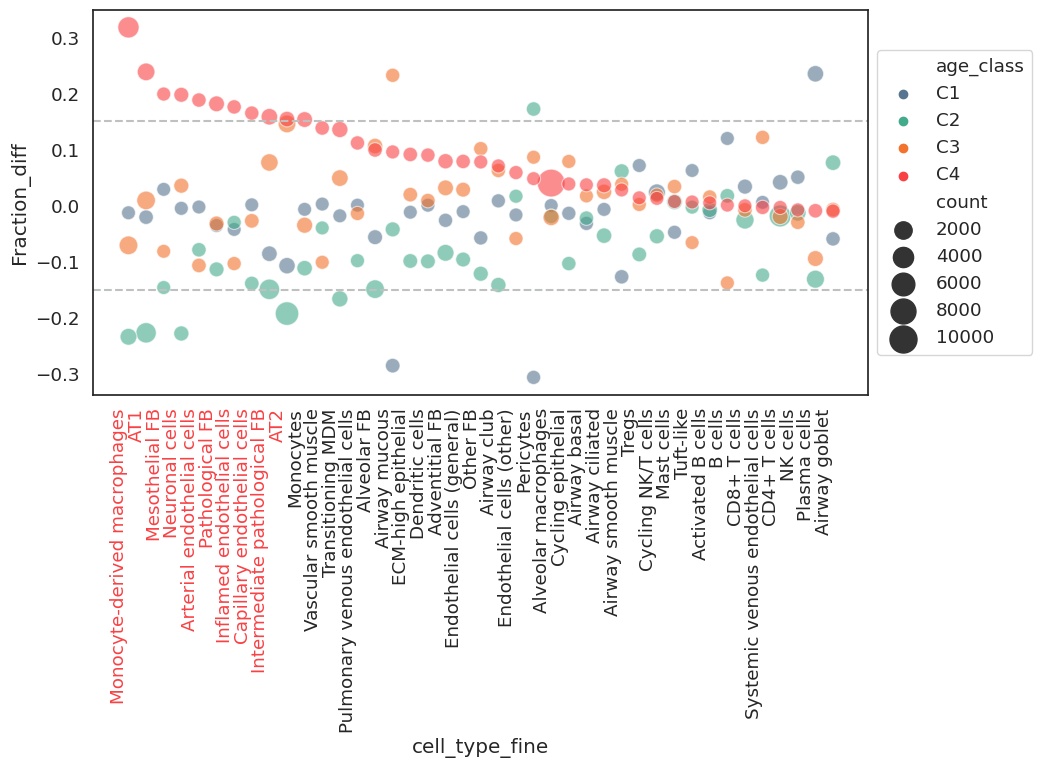

In [113]:
sns.set(rc={'figure.figsize':(10,5)},font_scale=1.2)
sns.set_style("white")
ax = sns.scatterplot(x='cell_type_fine',
                        y='Fraction',
                        hue = 'age_class',
                        size = 'count',
                        data=df,
                        sizes=(100, 400),
                        palette=['#577590','#43aa8b','#f3722c','#f94144'],
                        alpha=0.6)
### plot yline 
plt.axhline(y=0.15, color='#bfc0c0', linestyle='--')
plt.axhline(y=-0.15, color='#bfc0c0', linestyle='--')
### out legend
plt.legend(bbox_to_anchor=(1,0.5), loc='center left', ncol=1)
plt.xticks(rotation=90,ha='right')
plt.setp(ax.get_xticklabels()[0:10], color='#f94144')
plt.ylabel('Fraction_diff')
plt.savefig("HUSI/Figures/model/Covid_Fra.png",dpi = 400,bbox_inches = 'tight')